# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import glob

# Data

In [ ]:
files = glob.glob("/content/drive/MyDrive/AI_FYP/*1h.csv")
files

['/content/drive/MyDrive/AI_FYP/ADAUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/BNBUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/ETHUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/LTCUSDT_1h.csv',
 '/content/drive/MyDrive/AI_FYP/BTCUSDT_1h.csv']

In [ ]:
df = pd.read_csv(files[-1])

In [ ]:
df["close"].pct_change().min(), df["close"].pct_change().max()

(-0.08954470284237714, 0.12315895662199172)

In [ ]:
if False:
  new_col = 'ret'
  for f in files:
    data_df = pd.read_csv(f)
    data_df = data_df[["close"]].pct_change().dropna()
    data_df = data_df.rename(columns={'close': new_col})
    ma_df = data_df.copy()

    for days in range(2, 52):
      name = f"SMA_{str(days)}"
      ma_df[name] = ma_df[new_col].rolling(days, min_periods=1).mean()
      data_df[name] = data_df[new_col]

    for days in range(2, 52):
      name = f"EMA_{str(days)}"
      ma_df[name] = ma_df[new_col].ewm(span=days, adjust=True).mean()
      data_df[name] = data_df[new_col]
      
    ma = ma_df.drop([new_col],axis=1)
    data = data_df.drop([new_col],axis=1)
    s1, s2 = f.split('.')
    data.to_csv(s1+f'_data.csv') 
    ma.to_csv(s1+f'_ma.csv') 

# NUMBER_OF_DAYS

In [ ]:
# window_size = number of data points in each data slice = 24 * NUMBER_OF_DAYS
NUMBER_OF_DAYS = 7
window_size = 24 * NUMBER_OF_DAYS

new_col = 'ret'
train_data_full , train_ma_full = np.zeros((52150, window_size, 100), dtype=np.float32), np.zeros((52150, window_size, 100), dtype=np.float32)
test_data_full , test_ma_full = np.zeros((12955, window_size, 100), dtype=np.float32), np.zeros((12955, window_size, 100), dtype=np.float32)
count_train, count_test = 0, 0

for f in files:
  data_df = pd.read_csv(f)
  data_df = data_df[["close"]].pct_change().dropna()
  data_df = data_df.rename(columns={'close': new_col})
  ma_df = data_df.copy()

  for days in range(2, 52):
    name = f"SMA_{str(days)}"
    ma_df[name] = ma_df[new_col].rolling(days, min_periods=1).mean()
    data_df[name] = data_df[new_col]

  for days in range(2, 52):
    name = f"EMA_{str(days)}"
    ma_df[name] = ma_df[new_col].ewm(span=days, adjust=True).mean()
    data_df[name] = data_df[new_col]

  # ma_df = ma_df.pct_change().dropna()
  # data_df = data_df.pct_change().dropna()

  ma = ma_df.drop([new_col],axis=1)
  data = data_df.drop([new_col],axis=1)
  del ma_df
  del data_df
  data = data.values
  ma = ma.values

  l = data.shape[0]
  idx = int(l*0.8)

  train_data,train_ma = data[:idx], ma[:idx]
  test_data,test_ma = data[idx:], ma[idx:]

  train_data_sli = np.lib.stride_tricks.sliding_window_view(train_data,(window_size ,train_data.shape[1])).squeeze().astype(np.float32)
  train_ma_sli = np.lib.stride_tricks.sliding_window_view(train_ma,(window_size ,train_ma.shape[1])).squeeze().astype(np.float32)

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(window_size ,test_data.shape[1])).squeeze().astype(np.float32)
  test_ma_sli = np.lib.stride_tricks.sliding_window_view(test_ma,(window_size ,test_ma.shape[1])).squeeze().astype(np.float32)
  """
  train_data_full.append(train_data_sli)
  train_ma_full.append(train_ma_sli)
  test_data_full.append(test_data_sli)
  test_ma_full.append(test_ma_sli)
  """
  n_train_sli, n_test_sli = train_data_sli.shape[0], test_data_sli.shape[0]
  train_data_full[count_train:count_train+n_train_sli] = train_data_sli
  train_ma_full[count_train:count_train+n_train_sli] = train_ma_sli
  test_data_full[count_test:count_test+n_test_sli] = test_data_sli
  test_ma_full[count_test:count_test+n_test_sli] = test_ma_sli
  count_train += n_train_sli
  count_test += n_test_sli


<ipython-input-7-e2335df6d8c0>:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ma_df[name] = ma_df[new_col].ewm(span=days, adjust=True).mean()
<ipython-input-7-e2335df6d8c0>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[name] = data_df[new_col]


In [ ]:
for arr in [train_data_full, train_ma_full, test_data_full, test_ma_full]:
    print(arr.shape, arr.dtype)

(52150, 168, 100) float32
(52150, 168, 100) float32
(12955, 168, 100) float32
(12955, 168, 100) float32


In [ ]:
n_train, n_test = train_data_full.shape[0], test_data_full.shape[0]
print(n_train, n_test)
train_idxes = np.random.choice(n_train, int(n_train/10))
test_idxes = np.random.choice(n_test, int(n_test/10))
print(train_idxes.shape, test_idxes.shape)

52150 12955
(5215,) (1295,)


In [ ]:
n_train, n_test = train_data_full.shape[0], test_data_full.shape[0]
print(n_train, n_test)
train_idxes = np.random.choice(n_train, int(n_train/10))
test_idxes = np.random.choice(n_test, int(n_test/10))
# print(train_idxes.shape, test_idxes.shape)
# train_data_full = train_data_full[train_idxes]
# train_ma_full = train_ma_full[train_idxes]
# test_data_full = test_data_full[test_idxes]
# test_ma_full = test_ma_full[test_idxes]

52150 12955


In [ ]:

for arr in [train_data_full, train_ma_full, test_data_full, test_ma_full]:
    print(arr.shape, arr.dtype)

(52150, 168, 100) float32
(52150, 168, 100) float32
(12955, 168, 100) float32
(12955, 168, 100) float32


## plot denoised data

(52150, 168, 100) (52150, 168, 100)
(168, 100) (168, 100)


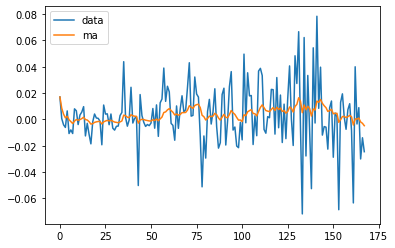

In [ ]:
print(train_data_full.shape, train_ma_full.shape)
idx = 0
print(train_data_full[idx].shape, train_ma_full[idx].shape)
plt.plot(train_data_full[idx][:, 0], label='data')
plt.plot(train_ma_full[idx].mean(axis=1), label='ma')
plt.legend()
assert (train_data_full[idx]==train_ma_full[idx]).all()!=True, "raw data is the same as denoised data"

## Dataloader

In [ ]:
class PriceDataset(Dataset):
    def __init__(self, input, output):
          self.input = torch.tensor(input)
          self.output = torch.tensor(output)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx].T
        y = self.output[idx].T

        return x, y

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_data_set = PriceDataset(train_data_full,train_ma_full)
del train_data_full
del train_ma_full

In [ ]:
test_data_set = PriceDataset(test_data_full,test_ma_full)
del test_data_full
del test_ma_full

In [ ]:
train_loader = DataLoader(train_data_set,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data_set,batch_size=BATCH_SIZE)

# Autoencoder

In [ ]:
class AE(nn.Module):
    def __init__(self, ma_size, n_point, **kwargs):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(ma_size, 30, 3, padding=1),
            nn.LeakyReLU(True),
            nn.Flatten(),
            nn.Linear(n_point*30, 180),
            nn.LeakyReLU(True),
            nn.Linear(180, 90),
        )

        self.decoder = nn.Sequential(
            nn.Linear(90,180),
            nn.LeakyReLU(True),
            nn.Linear(180,n_point*30),
            nn.LeakyReLU(True),
            nn.Unflatten(dim=1,unflattened_size=(30, n_point)),
            nn.ConvTranspose1d(30, ma_size, 3, padding=1)
        )

    def forward(self,x,training=False):
      x = self.encoder(x)
      if training:
        x = self.decoder(x)
      return x

In [ ]:
epochs = 300
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
n = train_data.shape[1]
ma_size, n_point = train_data.shape[1], window_size
print(f'device: {device}, ma_size: {ma_size}, n_point: {n_point}')
model = AE(ma_size, n_point).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

device: cuda, ma_size: 100, n_point: 168


In [ ]:
# Train
log_loss=[]
train_loss = []
test_loss = []
model.train()
for epoch in range(epochs):
    total_loss = 0
    for data, denoised in train_loader:
      data = data.to(device) 
      denoised = denoised.to(device)
      # Forward
      output = model(data, training=True)
      loss = loss_function(output, denoised)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()
      total_loss+=loss
      log_loss.append(loss.item())
    total_loss /= len(train_loader.dataset)
    train_loss.append(total_loss.item())
    scheduler.step()
    
    if epoch % 10 ==0:
    #if True:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/300] Loss: 2.507420902020385e-07
[11/300] Loss: 1.0403208072773396e-08
[21/300] Loss: 9.742688433789226e-09
[31/300] Loss: 9.420123348036213e-09
[41/300] Loss: 9.011435153638558e-09
[51/300] Loss: 8.993382927258153e-09
[61/300] Loss: 8.963426445518508e-09
[71/300] Loss: 8.94147156316194e-09
[81/300] Loss: 8.923976224650687e-09
[91/300] Loss: 8.91525875346133e-09
[101/300] Loss: 8.903904280543884e-09
[111/300] Loss: 8.893177749769166e-09
[121/300] Loss: 8.883667135251017e-09
[131/300] Loss: 8.871492873652187e-09
[141/300] Loss: 8.866255285511215e-09
[151/300] Loss: 8.857079514257293e-09
[161/300] Loss: 8.852484079113765e-09
[171/300] Loss: 8.845793431078164e-09
[181/300] Loss: 8.841248622104558e-09
[191/300] Loss: 8.836726905769865e-09
[201/300] Loss: 8.832609310616135e-09
[211/300] Loss: 8.829191600057129e-09
[221/300] Loss: 8.826300579301005e-09
[231/300] Loss: 8.822779840045314e-09
[241/300] Loss: 8.820014940624787e-09
[251/300] Loss: 8.8169542777905e-09
[261/300] Loss: 8.81484840

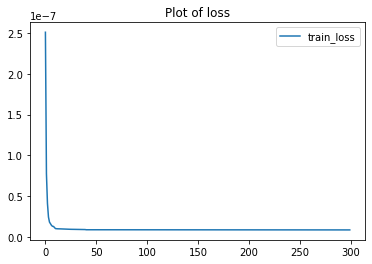

In [ ]:
plt.plot(train_loss, label='train_loss')
plt.title('Plot of loss')
plt.legend()
plt.show()

In [ ]:
output.shape

torch.Size([54, 100, 168])

# Inference on train data

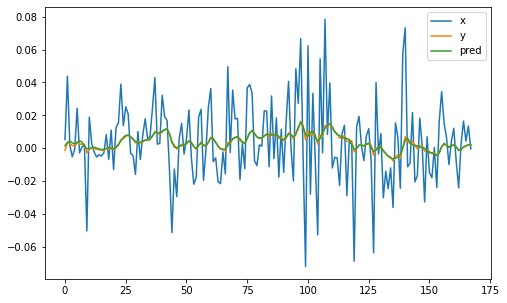

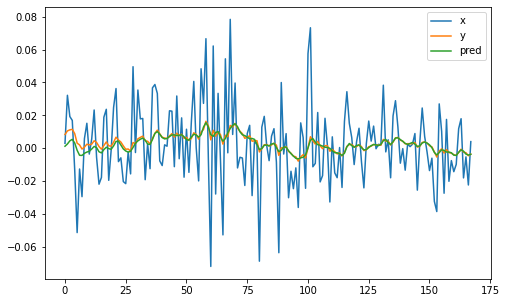

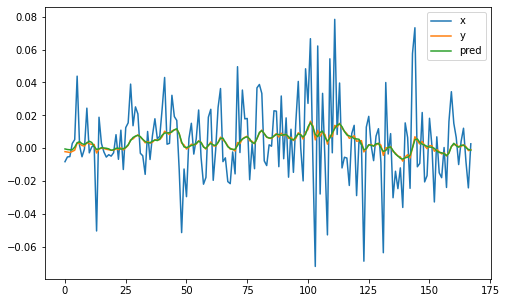

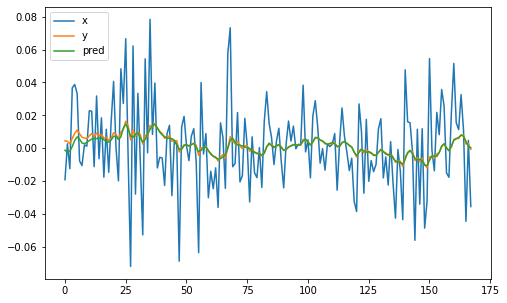

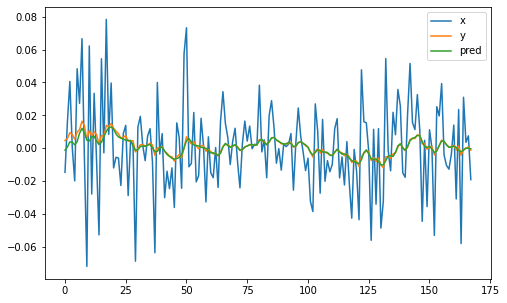

In [ ]:
# x = inputs[0].detach().numpy()*std+mean
# y = output[0].detach().numpy()*std+mean
for data, denoised in iter(train_loader):
  data = data.to(device) 
  denoised = denoised.to(device)
  break
model.eval()
output = model(data, training=True)
count = np.arange(window_size)
nrow, ncol = 1, 1
n_data, n_example = output.shape[0], 5
idxes = np.random.choice(n_data, n_example)

for idx in idxes:
    x = data[idx].cpu().detach().numpy()
    y = denoised[idx].cpu().detach().numpy()
    pred = output[idx].cpu().detach().numpy()

    fig, ax = plt.subplots(nrow, ncol, figsize=(8*nrow, 5*ncol))
    ax.plot(count, x[0], label="x")
    ax.plot(count, y.mean(axis=0), label="y")
    ax.plot(count, pred.mean(axis=0), label="pred")
    ax.legend()        

In [ ]:
torch.save(model, f'/content/drive/MyDrive/AI_FYP/ae_day_{NUMBER_OF_DAYS}.pt')

# Inference on test data

In [ ]:
model.zero_grad()
model.eval()
log_loss=[]
total_loss = 0
for data,denoised in test_loader:
    inputs = data.to(device) 
    denoised = denoised.to(device)
    # Forward
    output = model(inputs,training=True)
    loss = loss_function(output, denoised)
    total_loss+=loss
    log_loss.append(loss)
total_loss /= len(test_loader.dataset)
print('Loss:', total_loss.item())

Loss: 5.8668914171278175e-09


128 5


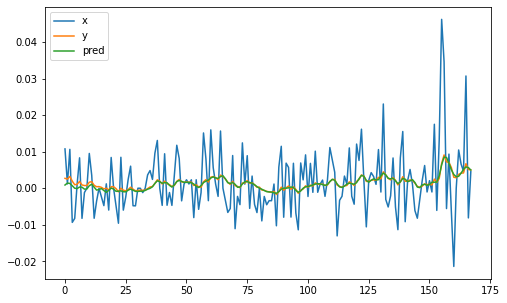

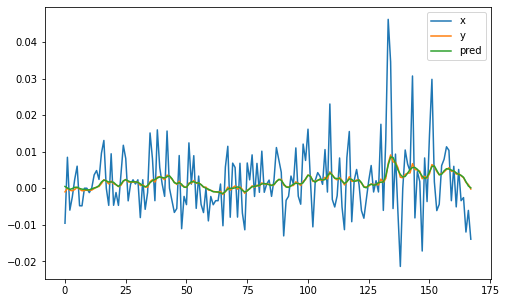

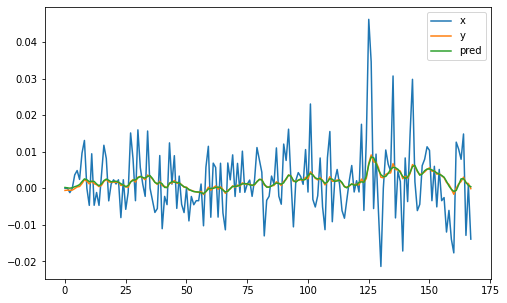

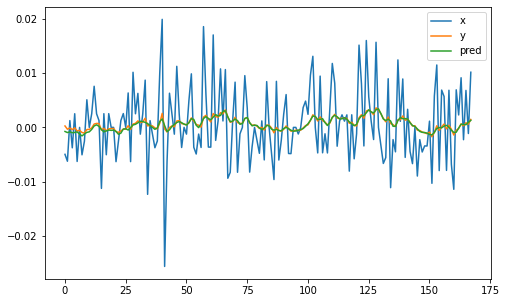

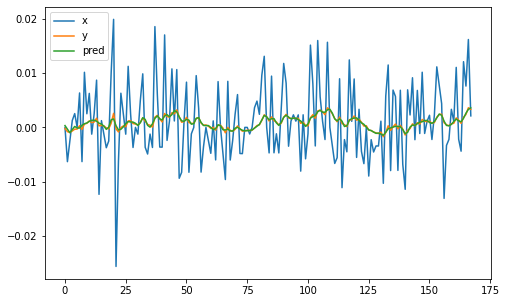

In [ ]:
for data, denoised in iter(test_loader):
  data = data.to(device) 
  denoised = denoised.to(device)
  break
model.eval()
output = model(data, training=True)
count = np.arange(window_size)
n_data, n_example = output.shape[0], 5
print(n_data, n_example)
idxes = np.random.choice(n_data, n_example)

for idx in idxes:
    x = data[idx].cpu().detach().numpy()
    y = denoised[idx].cpu().detach().numpy()
    pred = output[idx].cpu().detach().numpy()

    fig, ax = plt.subplots(nrow, ncol, figsize=(8*nrow, 5*ncol))
    ax.plot(count, x[0], label="x")
    ax.plot(count, y.mean(axis=0), label="y")
    ax.plot(count, pred.mean(axis=0), label="pred")
    ax.legend()        

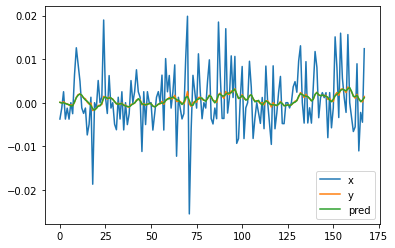

In [ ]:
x = data[1].cpu().detach().numpy()
y = denoised[1].cpu().detach().numpy()
pred = output[1].cpu().detach().numpy()
count = np.arange(window_size)

plt.plot(count,x[0],label="x")
plt.plot(count,y.mean(axis=0),label="y")
plt.plot(count,pred.mean(axis=0),label="pred")
plt.legend()

In [ ]:
def get_data(n=25):
    data_df = pd.read_csv("/content/drive/MyDrive/AI_FYP/BTCUSDT_1h.csv")
    data = data_df["close"].pct_change().dropna()
    data = data.values
    # data_sli = np.lib.stride_tricks.sliding_window_view(data,(n))
    # y = np.array([1 if arr[-1]>0  else 0 for arr in data_sli]).astype(np.float32)
    # l = data.shape[0]
    # idx = int(l*0.8)
    # data = data[idx:]

    x = data
    tmp = data
    for i in range(99):
      tmp = np.vstack((tmp,x))

    data_sli = tmp.T
    data_sli = np.lib.stride_tricks.sliding_window_view(data_sli,(n,data_sli.shape[1])).squeeze().astype(np.float32)

    y = np.array([1 if arr[-1][0]>0  else 0 for arr in data_sli]).astype(np.float32)
    return data_sli[:,:-1,:],y

x,y=get_data()
print(f'x: {x.shape}, y: {y.shape}')

FileNotFoundError: ignored

In [ ]:
class PriceDataset_testing(Dataset):
    def __init__(self, input):
          self.input = torch.tensor(input)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx].T
        return x

dset = PriceDataset_testing(x)
loader = DataLoader(dset,batch_size=BATCH_SIZE)

In [ ]:
dset[0].shape

In [ ]:
out = []
model.eval()
for data in loader:
  data = data.to(device)
  # Forward
  output = model(data,training=True)
  out.append(output.cpu().detach().numpy())

In [ ]:
denoised_x = np.concatenate(out)

In [ ]:
denoised_x=denoised_x.mean(axis=1)

In [ ]:
denoised_x

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def train_SVM(X, y):
    from sklearn.svm import SVC
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    return clf
def get_acc(clf,x, y, v=False):  
    out = clf.predict(x)
    acc = np.mean(out==y)
    if v:
        print(out)
        print(y)
    return acc

l = int(denoised_x.shape[0]*0.8)
train_x,train_y = denoised_x[:l],y[:l]
test_x,test_y = denoised_x[l:],y[l:]

clf = train_SVM(train_x, train_y)
print('Denoised Input, Denoised Label\n'+'-'*60)
print(f'train_acc: {get_acc(clf, train_x, train_y):.3f}')
print(f'test_acc: {get_acc(clf, test_x, test_y):.3f}')

In [ ]:
denoised_x.shape